In [139]:
suppressWarnings(suppressMessages({
    library(tidyverse)
    library(lme4)
    library(effects)
    library(gtsummary)
    library(lubridate)
    library(nlme)
    library(sjPlot)
    library(fastDummies)
}))

In [7]:
metrics_fit <- read.csv("~/datamining-analysis/osat/gitignore/metrics_fit_for_save.csv")

In [8]:
metrics_fit <- metrics_fit %>%
    group_by(BID, time_factor) %>%
    slice_head()

dim(metrics_fit)

[1] 106   6

In [9]:
metrics_fit$StudyGroup <- as.numeric(as.factor(metrics_fit$StudyGroup))
metrics_fit$time_factor <- as.numeric(as.factor(metrics_fit$time_factor))

$# time_factor = {1, 2, 3, 4}
  StudyGroup = {1, 2}
  Y = Hmotnost
  BID = 1 , ... , 31 $

#### time_factor = {1, 2, 3, 4}
#### StudyGroup = {1, 2}
####  Y = Hmotnost
####  BID = 1 , ... , 31 

In [10]:
metrics_fit %>% head()

X,BID,date,time_factor,StudyGroup,value1
<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,505703/103,2021-07-12,1,1,108
21,505703/103,2021-10-18,2,1,98
29,505703/103,2022-01-09,3,1,95
41,505703/103,2022-04-10,4,1,97
47,511218/169,2022-04-12,1,2,115
92,511218/169,2022-07-12,2,2,115


`geom_smooth()` using formula = 'y ~ x'


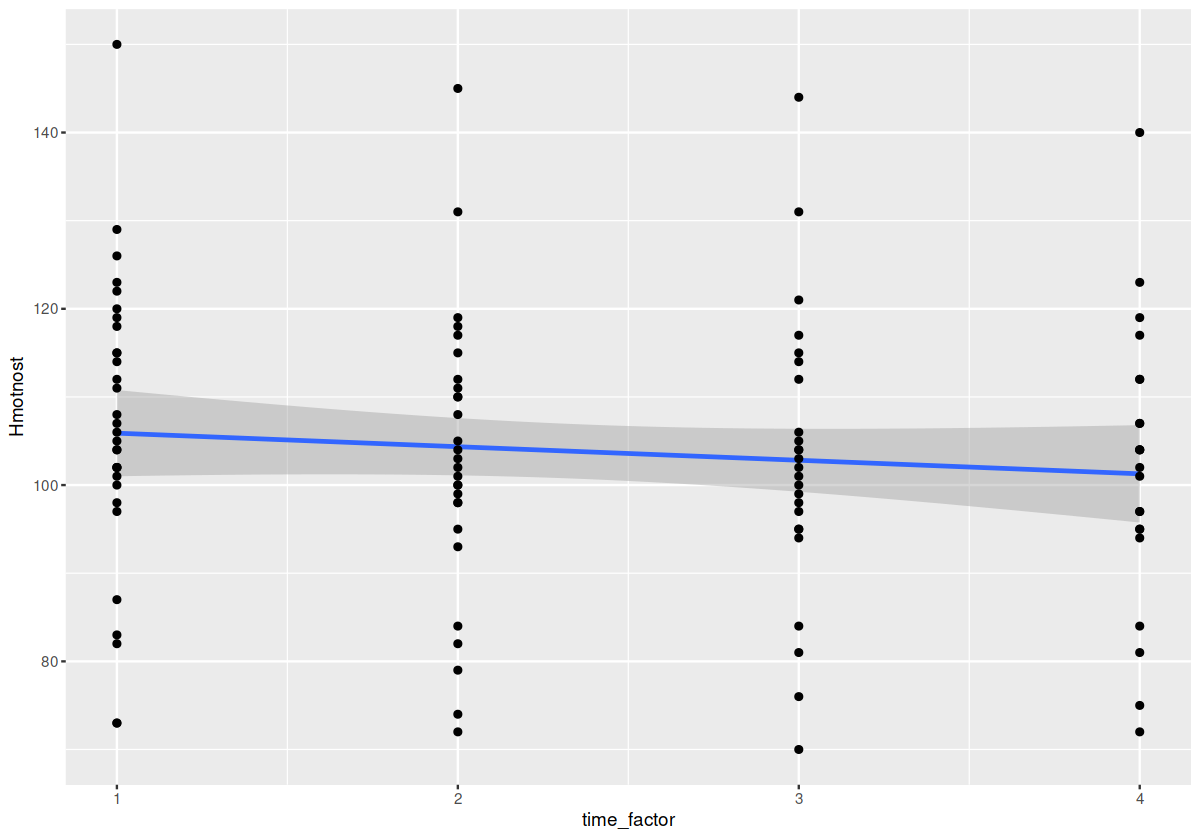

In [1603]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(metrics_fit, aes(x=time_factor,y=value1)) + 
    geom_smooth(method = "lm") + 
    geom_point() +
    ylab("Hmotnost")

In [1613]:
# OLS 
ols <- lm(value1 ~ 1, metrics_fit)
summary(ols)

# paste("Mean weight = ", mean(metrics_fit$value1))


Call:
lm(formula = value1 ~ 1, data = metrics_fit)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.802  -6.802   0.198   9.698  46.198 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  103.802      1.562   66.47   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.08 on 105 degrees of freedom


##### $$ b = (X^{T}X)^{-1}X^{T}y $$

In [1629]:
# maticovy vypocet interceptu b0

Y = as.matrix(metrics_fit %>%
                select(value1) %>% pull)
X = as.matrix(rep(1, length(Y)))
b0 = solve(t(X) %*% X) %*% t(X) %*% Y 

b0

Adding missing grouping variables: `BID`, `time_factor`


103.8019


#### $$ t = \frac{b_{0}}{ SE } $$
##### $$ SE = \sqrt{var(e)*(X^{T}X)^{-1} } $$

In [1622]:
e = Y - X %*% b0
SE = sqrt(var(e) %*% solve(t(X) %*% X))
t = b0 / SE
paste("t = ", t)

[1] "t =  66.4748234525267"

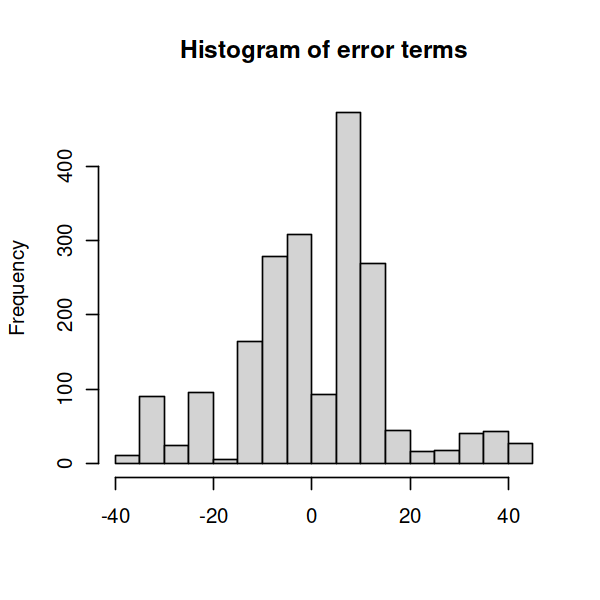

In [16]:
options(repr.plot.width=5, repr.plot.height=5)

hist(e, main = "Histogram of error terms", xlab = "")

 #### Mixed models
 
 $$ Y = Xb + ZU + e $$

 $$ Y \sim N(Xb, \sigma^{2}I + ZDZ^{T}) $$
 
  $$ e \sim N(0, \sigma^{2}) $$
  
   $$ u \sim N(0, D) $$

####  1. For each BID calulate random intercept (ML method) as follows:

##### $$ u_{i} = D Z_{i}^{T} V^{-1}_{i} e_{i} $$
##### $ i $ = number of values for each BID

`geom_smooth()` using formula = 'y ~ x'
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


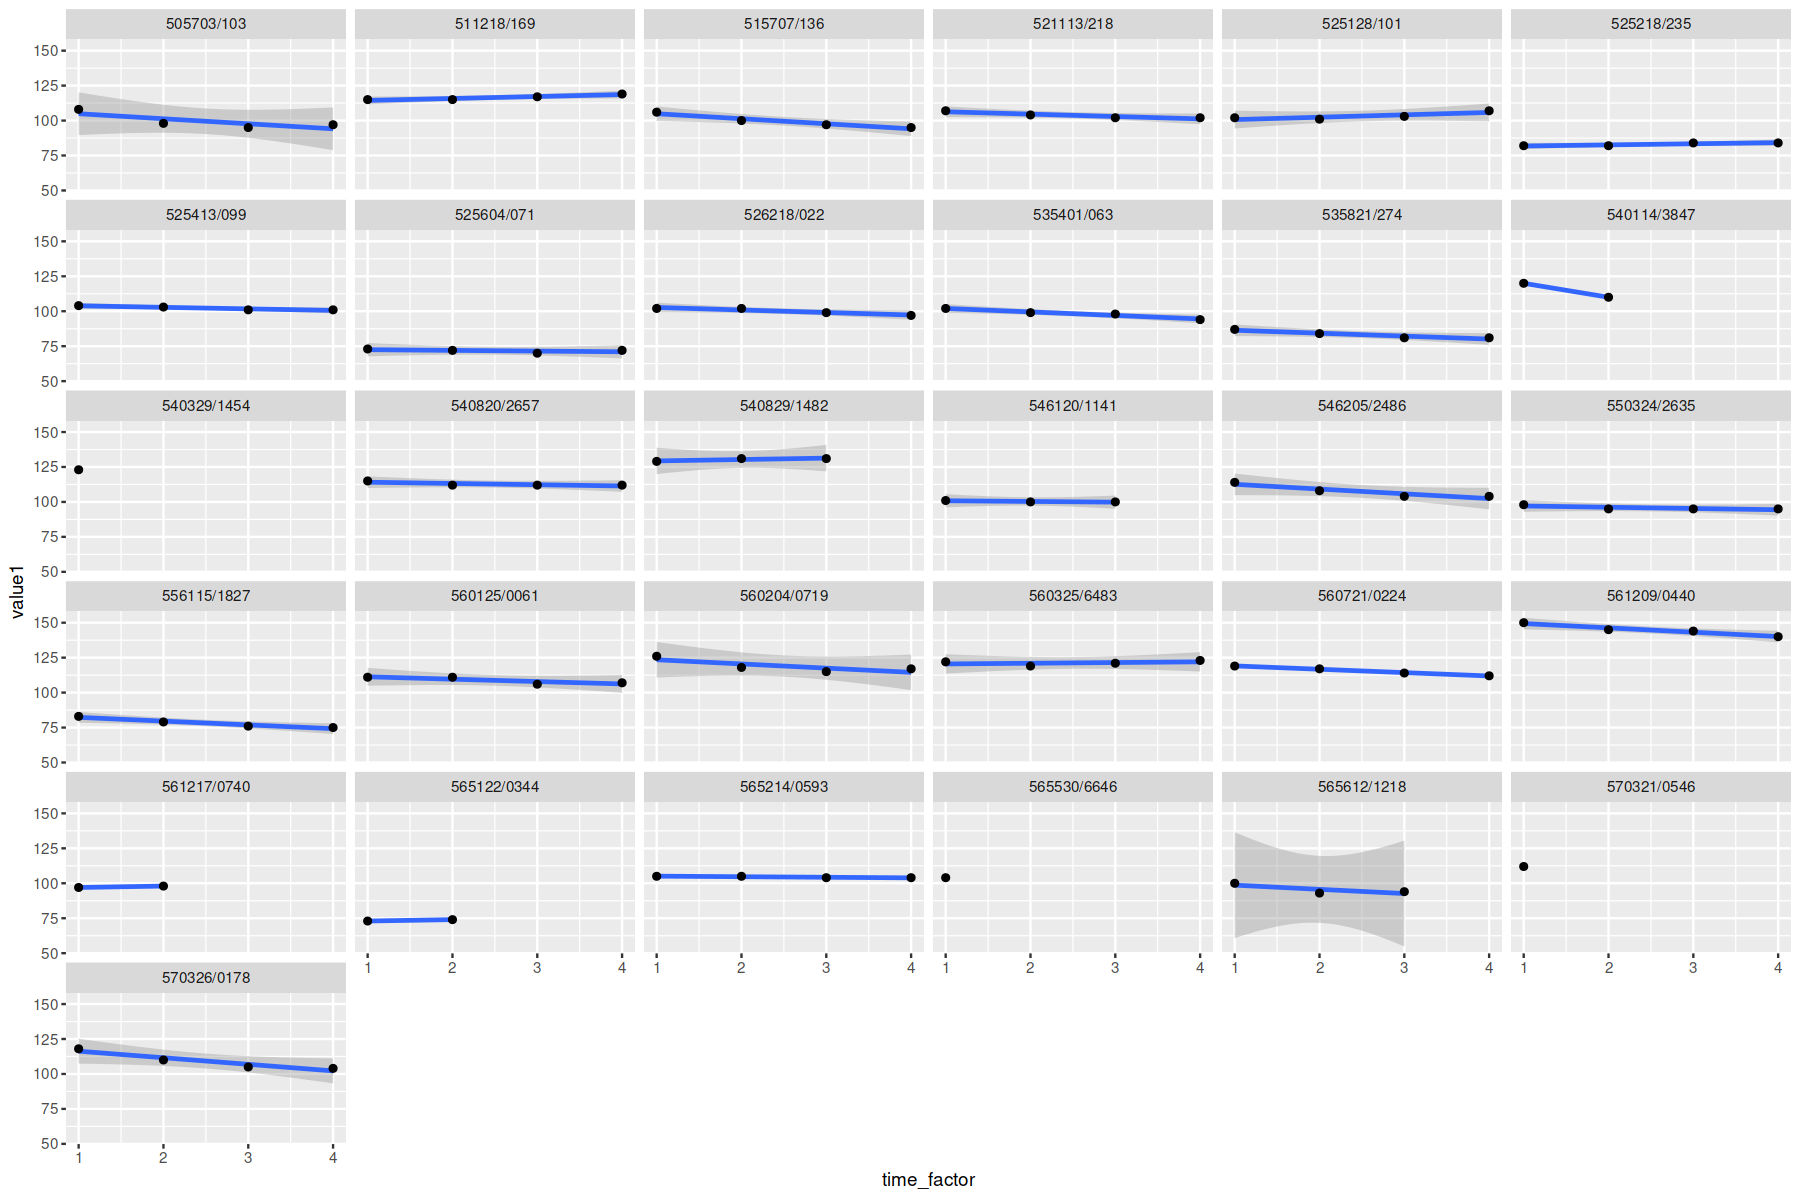

In [1915]:
options(repr.plot.width=15, repr.plot.height=10)

ggplot(metrics_fit, aes(x=time_factor,y=value1)) + 
    geom_smooth(method = "lm") + 
    geom_point() + 
    facet_wrap(~BID) 

### EM algorithm

#### E - step

In [ ]:
# set priors (E-step):

b = 0 
sigma = 1 
D = matrix(1) 

#### M - step


##### $$ b_{t+1} = (\sum X_{i}^{T} W_{i} X_{i})^{-1}\sum (X_{i}^{T} W_{i} y_{i}) $$

##### $$ D_{t+1} = (\sum u_{t}u_{t}^{T} + D(I - Z_{t}^{T} W_{t} Z_{t} D_{t}) $$


##### $$ sigma_{t+1} = \frac{ \sum(e_{t}e_{t}^{T} + sigma_{t} tr(I - sigma_{t} W_{t})}{N}  $$


In [1916]:
# for BID 1 estimate random intercept

# Y = as.matrix(metrics_fit %>% 
#                 filter(BID == unique(BID)[1]) %>% 
#                 select(value1) %>% pull)


# X = rep(1, length(Y)) # 1 x 46
# Z = rep(1, length(Y)) # 1 x 46 
# I = diag(length(Y)) # 46 x 46

# V = sigma * I + Z %*% D %*% t(Z) # 46 x 46 
# W = solve(V)


# r = Y - (X) %*% t(b) # (y - Xb) residual from ols r=Y
# # calculate random intercept for BID1
# u = D %*% t(Z) %*% W %*% r
# u
#   e = r - (Z %*% u) 
  
#   # for b recalculation 
#   cov_list = c(cov_list, t(X) %*% W %*% Y)
#   var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
#   # for sigma and D recalculation 
#   sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
#   D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D))

#### In a same way estimate random intercept for each BID with priors (b=0, sigma = 1, D = matrix(1)).
#### Saving each random intercept $ u_{i} $ and residual variance $ e_{ij} $, 
#### where $ i $ = 1, ... , 31

In [1920]:
# ML
# loop across every BID
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

bids <- unique(metrics_fit$BID)

In [1921]:
n = 10

for (j in 1:n) { 
    
  sigma_list <- c()
  D_list <- c()
  cov_list <- c()
  var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2) (u = r in a balanced dataset)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D)) #  D * (diag(1) - t(Z) %*% W %*% Z %*% D) = 0 in a balanced dataset

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)
    

b_values[j] = b
sigma_values[j] = sigma
D_values[j] = D
}

In [1922]:
c(D, sigma, b) 

[1] 243.05596  10.86734 104.16031

In [1711]:
summary(lmer.mod.ML)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

     AIC      BIC   logLik deviance df.resid 
   692.3    700.3   -343.2    686.3      103 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57609 -0.52824 -0.09361  0.28133  2.67231 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 243.07   15.591  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.160      2.822   36.91

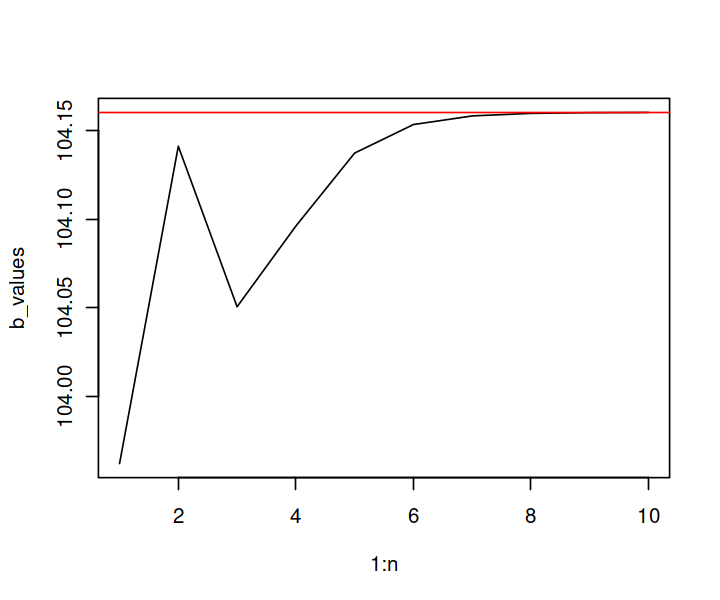

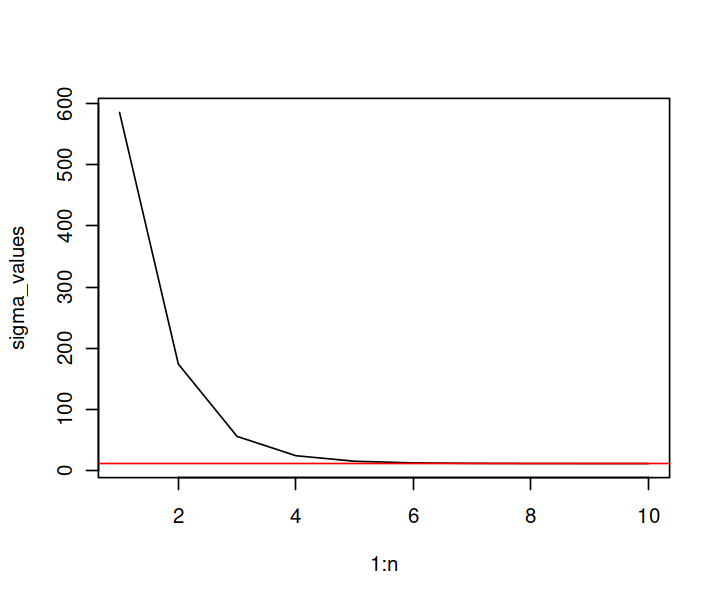

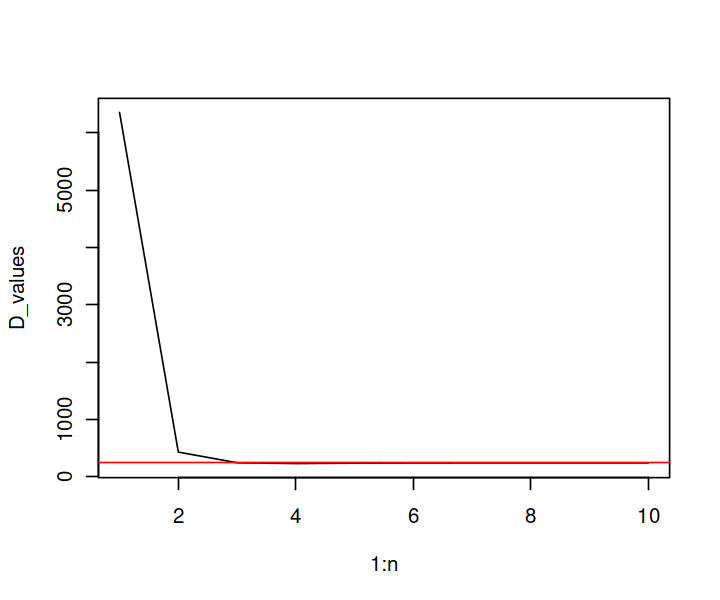

In [1923]:
options(repr.plot.width=6, repr.plot.height=5)

plot(1:n, b_values, type="l")
abline(h=b, col='red')
plot(1:n, sigma_values, type="l")
abline(h=sigma(lmer.mod.ML)^2, col='red')
plot(1:n, D_values, type="l")
abline(h=VarCorr(lmer.mod.ML)[[1]]%>% as.vector(), col='red')

In [1645]:
# REML
# loop across every BID
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1646]:
n = 10

for (j in 1:n) { 
    
  sigma_list <- c()
  D_list <- c()
  cov_list <- c()
  var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  P = W %*% (I - X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W) # (3.10)
  # P = W - W %*% X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W # (3.10)
 
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% P %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * P)))
  D_list = c(D_list, u %*% t(u) + D %*% (diag(1) - t(Z) %*% P %*% Z %*% D)) 
}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(bid), 1)
    

b_values[j] = b
sigma_values[j] = sigma
D_values[j] = D
}

In [1647]:
c(D, sigma, b)

[1] 8.196258e+14 3.622212e+02 1.041801e+02

#### $$ P = W (I - X \sum(X^{T}WX)^{-1}X^{T}W $$

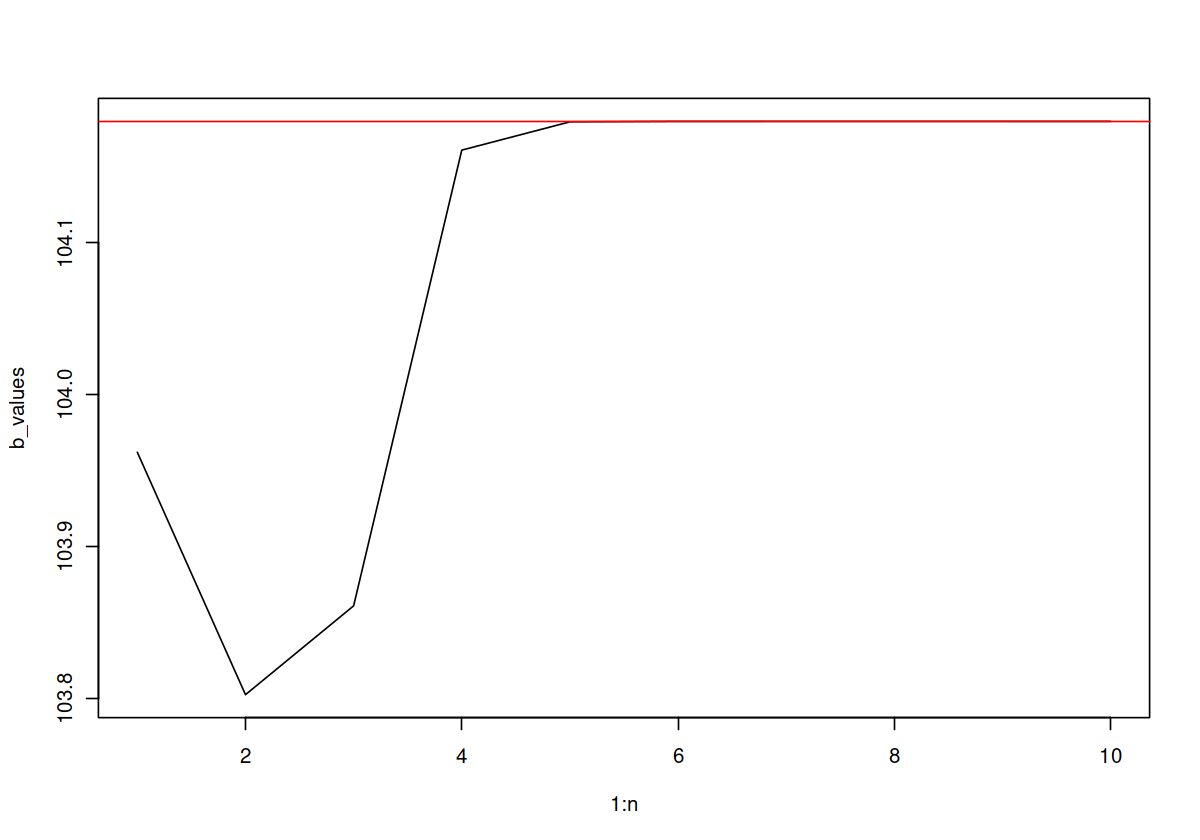

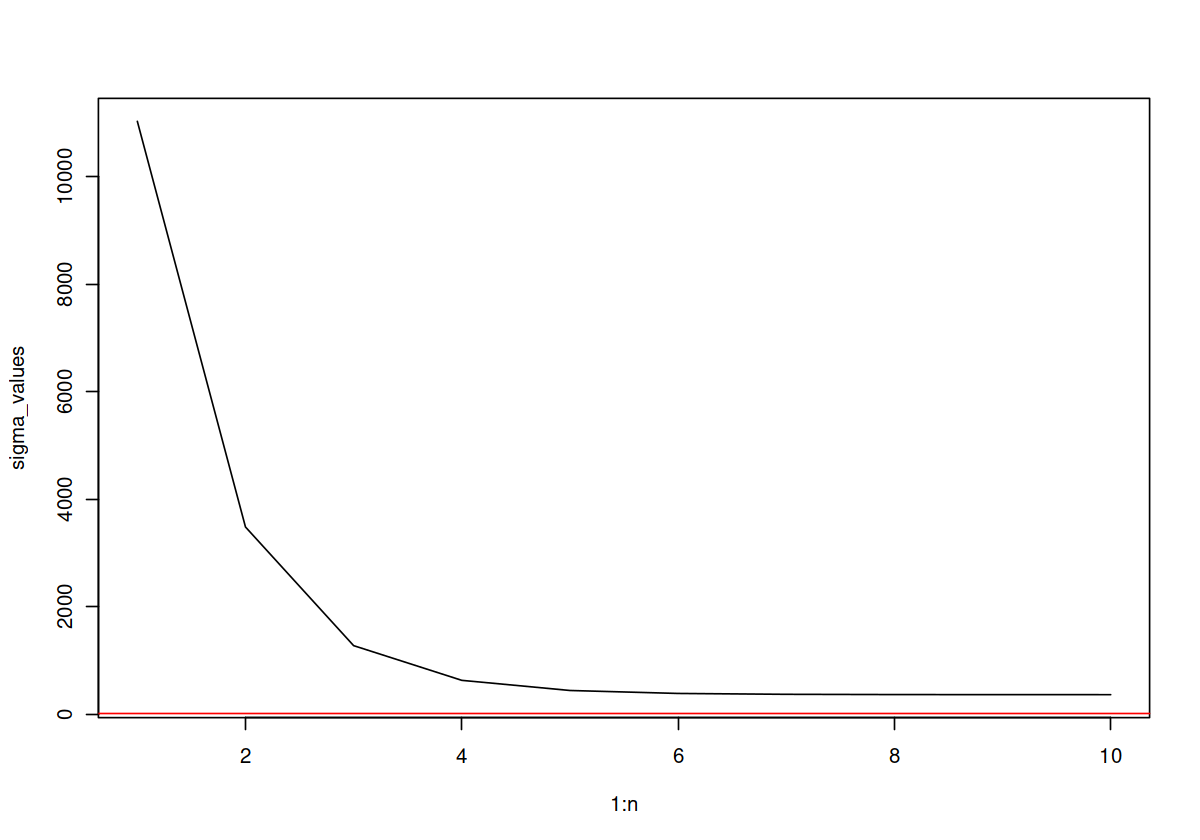

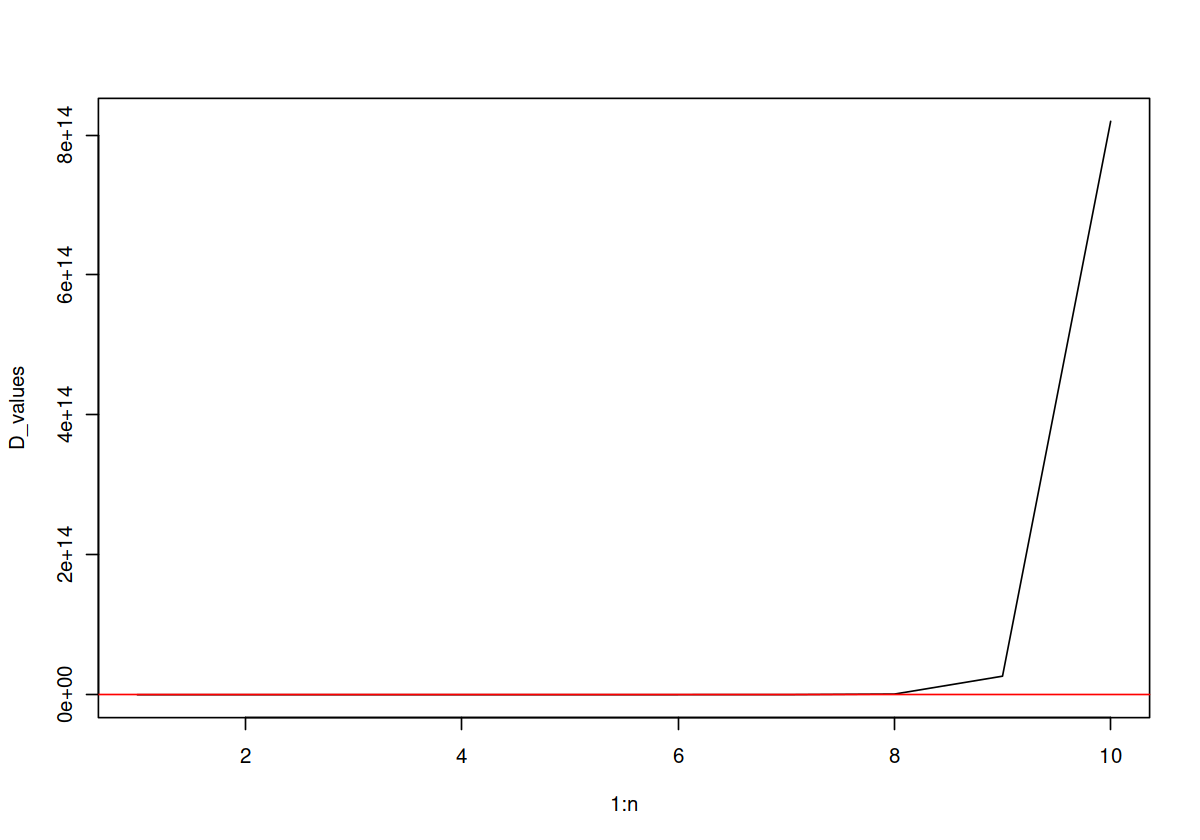

In [1648]:
plot(1:n, b_values, type="l")
abline(h=b, col='red')
plot(1:n, sigma_values, type="l")
abline(h=sigma(lmer.mod.REML)^2, col='red')
plot(1:n, D_values, type="l")
abline(h=VarCorr(lmer.mod.REML)[[1]]%>% as.vector(), col='red')

In [1924]:
# ML
# rucne
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1937]:
sigma_list <- c()
D_list <- c()
cov_list <- c()
var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                filter(BID == bids[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% W %*% Z %*% D))

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)

paste('(ML) sigma =', sigma)
paste('(ML) b =', b)
paste('(ML) D =', D)

[1] "(ML) sigma = 10.8595534260243"

[1] "(ML) b = 104.160361480628"

[1] "(ML) D = 243.064939992393"

In [1680]:
lmer.mod.ML = lmer(value1 ~ 1 + (1|BID), data = metrics_fit, REML = F)
summary(lmer.mod.ML)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

     AIC      BIC   logLik deviance df.resid 
   692.3    700.3   -343.2    686.3      103 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57609 -0.52824 -0.09361  0.28133  2.67231 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 243.07   15.591  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.160      2.822   36.91

In [1818]:
# REML
# rucne
  
D = matrix(1)
sigma = 1
b = 0

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1819]:
sigma_list <- c()
D_list <- c()
cov_list <- c()
var_list <- c()
  
for (bid in 1:length(unique(metrics_fit$BID))) {
  
  Y = as.matrix((metrics_fit %>% 
                  filter(BID == unique(BID)[bid]))$value1)

  X = as.matrix(rep(1,nrow(Y)))
  Z = rep(1, nrow(Y))
  I = diag(nrow(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  P = W %*% (I - X %*% solve(sum(t(X) %*% W %*% X)) %*% t(X) %*% W) # (3.10)
    
  r = Y - (X) %*% t(b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2)
  e = r - (Z %*% u) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y)
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * P)))
  D_list = c(D_list, u %*% t(u) + D * (diag(1) - t(Z) %*% P %*% Z %*% D)) 

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/nrow(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)

paste('(REML) sigma =', sigma)
paste('(REML) b =', b)
paste('(REML) D =', D)

ERROR: Error in solve.default(V): 'a' is 0-diml


In [1681]:
lmer.mod.REML = lmer(value1 ~ 1 + (1|BID), data = metrics_fit, REML = TRUE)
summary(lmer.mod.REML)

Linear mixed model fit by REML ['lmerMod']
Formula: value1 ~ 1 + (1 | BID)
   Data: metrics_fit

REML criterion at convergence: 682.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.57663 -0.52832 -0.09549  0.28081  2.67173 

Random effects:
 Groups   Name        Variance Std.Dev.
 BID      (Intercept) 251.28   15.852  
 Residual              10.86    3.295  
Number of obs: 106, groups:  BID, 31

Fixed effects:
            Estimate Std. Error t value
(Intercept)  104.161      2.869   36.31

# metrics_fit_full <- metrics_fit

$$
\begin{bmatrix}
R_{1} & 0 & \cdots & 0 \\
0 & R_{2} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & R_{n}
\end{bmatrix} \tag{3-8}
$$

### VarCov matrix

#### Compound symmetry

In [1823]:
# compound symmetry structure with lme

fit <- lme(value1 ~ factor(time_factor), 
            random = ~1|BID,  
            data = metrics_fit,
            method="ML")

VarCorr(fit)

BID = pdLogChol(1) 
            Variance   StdDev   
(Intercept) 242.461784 15.571184
Residual      6.224912  2.494977

In [1907]:
# round(getVarCov(fit, type= "marginal", individual = 1)[[1]],2)
getVarCov(fit, type= "marginal", individual = 24)

BID 561209/0440 
Marginal variance covariance matrix
       1      2      3      4
1 248.69 242.46 242.46 242.46
2 242.46 248.69 242.46 242.46
3 242.46 242.46 248.69 242.46
4 242.46 242.46 242.46 248.69
  Standard Deviations: 15.77 15.77 15.77 15.77 

$$
\begin{bmatrix}
\sigma^{2} + \tau & \tau & \cdots & \tau \\
\tau & \sigma^{2} + \tau & \cdots & \tau \\
\vdots & \vdots & \ddots & \vdots \\
\tau & \tau & \cdots & \sigma^{2} + \tau
\end{bmatrix} \tag{3-8}
$$

#### Unstructured

In [24]:
metrics_fit$time_factor <- as.factor(metrics_fit$time_factor)

In [26]:
#  unstructured covariance matrix

fit2 <- lme(value1 ~ factor(time_factor), 
            random = ~(time_factor)|BID, 
            data = metrics_fit,
            method="ML")

In [27]:
# ...getVarCov doesnt give the correct matrix (r cant be negative)

getVarCov(fit2) 

Random effects variance covariance matrix
             (Intercept) time_factor2 time_factor3 time_factor4
(Intercept)      260.740     -16.4860      -19.516      -26.668
time_factor2     -16.486       9.6021       13.072       13.207
time_factor3     -19.516      13.0720       19.880       21.910
time_factor4     -26.668      13.2070       21.910       26.510
  Standard Deviations: 16.147 3.0987 4.4587 5.1487 

In [28]:
# ...getVarCov doesnt give the correct matrix (r cant be negative)

getVarCov(fit2)[1:4,1:4]

,(Intercept),time_factor2,time_factor3,time_factor4
(Intercept),260.74005,-16.486354,-19.51645,-26.66753
time_factor2,-16.48635,9.602065,13.07216,13.20717
time_factor3,-19.51645,13.072160,19.88021,21.91041
time_factor4,-26.66753,13.207172,21.91041,26.50960


In [38]:
D <- getVarCov(fit2, type ="random") # D
d <- dummy_cols((metrics_fit %>% filter(BID==unique(BID)[1]))$time_factor)[,-c(1,2)]
Z <- cbind(rep(1,5), as.matrix(d)[1:5,])
Z

,.data_2,.data_3,.data_4
1,0,0,0
1,1,0,0
1,0,1,0
1,0,0,1
1,0,0,0


 $$ Y \sim N(Xb,  \sigma^{2}I + ZDZ^{T}) $$

In [36]:
# this one is correct unstructured matrix

sigma(fit2)*diag(5) + (Z) %*% as.matrix(D) %*% t(Z)

261.5320,244.2537,241.2236,234.0725,260.7400
244.2537,238.1614,237.8094,230.7933,244.2537
241.2236,237.8094,242.3793,236.4665,241.2236
234.0725,230.7933,236.4665,234.7066,234.0725
260.7400,244.2537,241.2236,234.0725,261.5320


#### AR(1)

In [1858]:
#  ar(1) covariance matrix

fit3 <- lme(value1 ~ factor(time_factor), 
    random = ~1|BID, 
    correlation = corAR1(form = ~1|BID),
    data = metrics_fit)

In [1859]:
corMatrix(fit3$modelStruct$corStruct)[[1]]

1.0000000,0.9865659,0.9733122,0.9602366
0.9865659,1.0000000,0.9865659,0.9733122
0.9733122,0.9865659,1.0000000,0.9865659
0.9602366,0.9733122,0.9865659,1.0000000


In [1804]:
AIC(fit) # compound symmetry

[1] 692.3451

In [1856]:
AIC(fit2) # AR(1) structure

[1] 622.4103

In [1835]:
AIC(fit3) # unstructured 

[1] 626.25

In [1851]:
#  ar(1) covariance matrix

fit3 <- lme(value1 ~ as.factor(time_factor), 
        random = ~as.factor(time_factor)|BID, 
        correlation = corAR1(form = ~1|BID),
        data = metrics_fit)

$$
\sigma^{2} \begin{bmatrix}
1 & \rho & \rho^{2} & \rho^{3} \\
\rho & 1 & \rho & \rho^{2} \\
\rho^{2} & \rho & 1 & \rho \\
\rho^{3} & \rho^{2} & \rho & 1
\end{bmatrix} \tag{3-8}
$$

In [1945]:
round(corMatrix(fit3$modelStruct$corStruct)[[1]], 3)

1.000,0.165,0.027,0.005
0.165,1.000,0.165,0.027
0.027,0.165,1.000,0.165
0.005,0.027,0.165,1.000


In [1947]:
0.165^2

[1] 0.027225

In [1853]:
AIC(fit3)

[1] 623.5491

In [1940]:
fit

Linear mixed-effects model fit by maximum likelihood
  Data: metrics_fit 
  Log-likelihood: -322.1637
  Fixed: value1 ~ factor(time_factor) 
         (Intercept) factor(time_factor)2 factor(time_factor)3 
          106.709677            -3.016870            -4.422874 
factor(time_factor)4 
           -4.677934 

Random effects:
 Formula: ~1 | BID
        (Intercept) Residual
StdDev:    15.57118 2.494977

Number of Observations: 106
Number of Groups: 31 

In [1954]:
library(nlme)

# Fit a model with an unstructured covariance matrix
model <- lme(value1 ~ as.factor(time_factor), 
             data = metrics_fit,
             random = pdBlocked(list(pdIdent(~ as.factor(time_factor) - 1 | BID),
                                    pdIdent(~ 1 | BID))))

ERROR: Error in getGroups.data.frame(dataMix, groups): invalid formula for groups


In [1863]:
df

id,y,t
<int>,<dbl>,<int>
1,11.176104,1
1,2.512867,2
1,19.228181,3
1,-1.511728,4
1,7.530189,5
2,9.131629,1
2,8.346321,2
2,4.949058,3
2,11.970271,4


In [1904]:
# ML
# loop across every BID
  
D = matrix(rep(1,4), 2)
sigma = 1
b = c(0,0)

b_values <- c()
sigma_values <- c()
D_values <- c()

In [1892]:
n = 10

for (j in 1:n) { 
    
  sigma_list <- c()
  D_list <- c()
  cov_list <- c()
  var_list <- c()
  
for (bid in 1:length(unique(df$id))) {
    
  Y <- df$y

  X = cbind(rep(1,length(Y)), df$t)
  Z = cbind(rep(1,length(Y)), df$t)
  I = diag(length(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% (b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2) (u = r in a balanced dataset)
  e = r - (Z %*% (u)) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y) # xwz not xwy
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(2) - t(Z) %*% W %*% Z %*% D))

}
    
# recalculate b
b = solve(sum(var_list)) %*% sum(cov_list)
# and recalculate sigma
sigma = sum(sigma_list)/length(metrics_fit)
# and recalculate D
D = diag(sum(D_list)/length(D_list), 1)
    

b_values[j] = b
sigma_values[j] = sigma
D_values[j] = D
}

ERROR: Error in Z %*% D: non-conformable arguments


In [1896]:
for (bid in 1:length(unique(df$id))) {
    
  Y <- df$y

  X = cbind(rep(1,length(Y)), df$t)
  Z = cbind(rep(1,length(Y)), df$t)
  I = diag(length(Y))
  
  V = sigma * I + Z %*% D %*% t(Z)
  W =  solve(V)
  
  r = Y - (X) %*% (b) # (y - Xb)
  u = D %*% t(Z) %*% W %*% r # (3.2) (u = r in a balanced dataset)
  e = r - (Z %*% (u)) 
  
  # for b recalculation 
  cov_list = c(cov_list, t(X) %*% W %*% Y) # xwz not xwy
  var_list = c(var_list, t(X) %*% W %*% X) # (3.3)
  
  # for sigma and D recalculation 
  sigma_list = c(sigma_list, t(e) %*% e + sigma * sum(diag(I - sigma * W)))
  D_list = c(D_list, u %*% t(u) + D * (diag(2) - t(Z) %*% W %*% Z %*% D))

}

In [1905]:
  Y <- df$y

  X = cbind(rep(1,length(Y)), df$t)
  Z = cbind(rep(1,length(Y)), df$t)
  I = diag(length(Y))
Y - (X) %*% (b)

11.176104
2.512867
19.228181
-1.511728
7.530189
9.131629
8.346321
4.949058
11.970271
9.145620
10.701391


In [1899]:
D_list

[1] 4.341565 2.788060 3.341565 3.788060 4.341565 2.788060 3.341565 3.788060
 [9] 4.341565 2.788060 3.341565 3.788060

In [1900]:
var_list

[1]  1.715867 -1.494465 -1.494465  2.269373  1.715867 -1.494465 -1.494465
 [8]  2.269373  1.715867 -1.494465 -1.494465  2.269373

In [1901]:
cov_list

[1]  15.57911 -13.69153  15.57911 -13.69153  15.57911 -13.69153

In [1902]:
solve(sum(var_list)) %*% sum(cov_list)

1.894573


In [738]:
Y = (metrics_fit$value1)
X = cbind(rep(1, length(Y)), metrics_fit$time_factor)
y=Y; id=metrics_fit$BID; X=X; A=X

In [741]:
em2.lmem <- function(y,id,X,A=X,niter=50,C=NULL) {
  uid <- unique(id)
  y <- as.matrix(y)
  X <- as.matrix(X)
  A <- as.matrix(A)
  N <- length(uid)
  n <- length(y)
  if (is.null(C)) 
    C <- matrix(1,ncol=ncol(A),nrow=ncol(A))
  
  beta <- as.vector(solve(t(X)%*%X)%*%t(X)%*%y)
  Omega <- diag(rep(1,ncol(A)))
  sigma2 <- 1
  LL <- NULL
  for (k in 1:niter) {
    iO <- solve(Omega)
    z <- as.vector(y - X%*%beta)
    R <- 0
    u <- NULL
    for (i in 1:length(uid)) {
      row.i <- which(id==id[i])
      Ai <- A[row.i,]
      zi <- z[row.i]
      Gammai <- solve(t(Ai)%*%Ai/sigma2 + iO)
      mui <- (Gammai%*%t(Ai)%*%zi)/sigma2
      u <- c(u, Ai%*%mui)
      R <- R + Gammai + mui%*%t(mui)
    }
    beta <- as.vector(solve(t(X)%*%X)%*%t(X)%*%(y-u))
    Omega <- as.matrix(R/N)
    sigma2 <- mean(y*(y - X%*%beta - u))
  }
  names(beta) <- row.names(Omega)
  return(list(beta=beta, Omega=Omega, sigma2=sigma2))
}

In [745]:
suppressWarnings(suppressMessages({
res.em1 <- em2.lmem(y=Y, id=(metrics_fit$BID), X=X, A=X)
print(res.em1)
}))

$beta
[1] 236.2201417   0.9530305

$Omega
         [,1]      [,2]
[1,] 6924.004 1979.4020
[2,] 1979.402  565.8988

$sigma2
[1] 254.8187



In [736]:
lmer(value1 ~ time_factor + (time_factor|BID), data=metrics_fit, REML=FALSE)

In [736]:
# Simulate a dataset for MML to compare with Linear regression.

In [52]:
library(tidyverse)
library(psych)
library(nlme)


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




,F1,V1,time,id
,<dbl>,<dbl>,<dbl>,<fct>
1,9528.291,8574.792,2,1
2,8165.638,7348.963,3,1
3,10860.680,9774.111,5,1
4,11289.182,10160.269,6,1
5,11434.299,10290.772,8,1
6,12993.368,11694.418,10,1



Call:
lm(formula = F1 ~ time, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
 -4813  -2809  -1363   2510   8278 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12946.797    770.409  16.805   <2e-16 ***
time           -1.286      3.233  -0.398    0.692    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3566 on 98 degrees of freedom
Multiple R-squared:  0.001611,	Adjusted R-squared:  -0.008577 
F-statistic: 0.1581 on 1 and 98 DF,  p-value: 0.6918


Linear mixed-effects model fit by REML
  Data: df 
       AIC      BIC    logLik
  1726.647 1736.987 -859.3236

Random effects:
 Formula: ~1 | id
        (Intercept) Residual
StdDev:    3523.482 1147.629

Fixed effects:  F1 ~ time 
                Value Std.Error DF   t-value p-value
(Intercept) 12946.797 1141.4704 89 11.342210  0.0000
time           -1.286    1.0405 89 -1.235552  0.2199
 Correlation: 
     (Intr)
time -0.193

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.20201559 -0.64483237 -0.01837308  0.59508143  2.50358816 

Number of Observations: 100
Number of Groups: 10 

Linear mixed-effects model fit by REML
  Data: df 
       AIC      BIC    logLik
  1702.398 1715.322 -846.1988

Random effects:
 Formula: ~1 | id
        (Intercept) Residual
StdDev:    3487.824 1324.491

Correlation Structure: AR(1)
 Formula: ~1 | id 
 Parameter estimate(s):
      Phi 
0.5991935 
Fixed effects:  F1 ~ time 
                Value Std.Error DF   t-value p-value
(Intercept) 12940.683 1179.0926 89 10.975120  0.0000
time           -1.402    1.6394 89 -0.855295  0.3947
 Correlation: 
     (Intr)
time -0.294

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-1.86872979 -0.53160911 -0.02124734  0.51396904  2.10923468 

Number of Observations: 100
Number of Groups: 10 

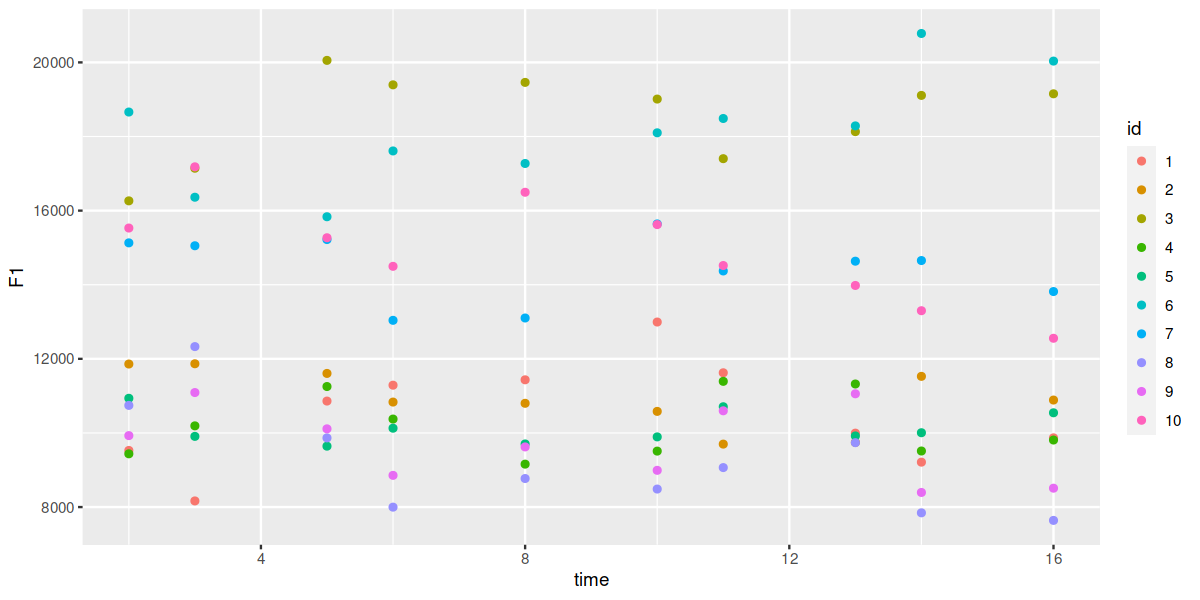

In [143]:
#First, show a few results from sim.multi
set.seed(11)
df <- sim.multi(n.obs = 10, nvar = 1, nfact = 1, ntrials = 10, 
                mu=7000, 
                sigma = 5000,
                sigma.i=1000, 
                AR1=1, plot=F) 

# BIDs n.obs=4 
df %>% 
    mutate(time = round(time/24),
          id = factor(id)) %>%
    head()

df %>% 
    mutate(time = round(time/24),
          id = factor(id)) %>%
    ggplot() +
    geom_point(aes(time, F1, col=id))

ols <- lm(F1 ~ time, df)
summary(ols)
fit <- lme(F1 ~ time, random=~1|id, df)
summary(fit)
ar1 <- lme(F1 ~ time, random=~1|id, correlation =  corAR1(form = ~1|id), df)
summary(ar1)

In [3]:
library(MASS)
library(nlme)
library(lme4)


Attaching package: ‘MASS’


The following object is masked from ‘package:gtsummary’:

    select


The following object is masked from ‘package:dplyr’:

    select




In [4]:
n <- 30  # Number of individuals
t <- 4    # Number of repeated measures (time points)
beta0 <- 5  # Intercept
beta1 <- 2  # Slope for time
sigma <- 1  # Residual standard deviation
# rho <- 0.5  # Correlation between repeated measures (compound symmetry structure)
rho <- 0.9  
time <- rep(1:t, each = n)
subject <- factor(rep(1:n, times = t))

Sigma_CS <- sigma^2 * (rho * matrix(1, t, t) + diag(1 - rho, t))
random_effects <- mvrnorm(n, rep(0, t), Sigma_CS)  # Random intercept with covariance structure

X_subject <- factor(rep(0:1, each = n / 2))  # 50% subjects in group 0, 50% in group 1
X <- rep(X_subject, each = t) 
beta1_group1 <- 0     # Slope for group 0 (X = 0)
beta1_group2 <- 0.5  # Slope for group 1 (X = 1)

# Create the linear predictor, including different slopes for each group
mu <- rep(beta0, n * t) + ifelse(X == 1, beta1_group2 * time, beta1_group1 * time)
Y <- mu + as.vector(random_effects) + rnorm(n * t, 0, sigma)

data <- data.frame(
  subject = factor(rep(1:n, each = t)),  # Each subject has 't' time points
  time = rep(1:t, times = n),
  X = factor(X),  # Treatment group
  Y = Y
)

data %>%
    arrange(subject) %>%
    head()

,subject,time,X,Y
,<fct>,<int>,<fct>,<dbl>
1,1,1,0,6.1531459
2,1,2,0,0.7819602
3,1,3,0,9.7894450
4,1,4,0,17.2200828
5,1,5,0,10.7213593
6,2,1,0,-6.2115982


In [5]:
ols <- lm(Y ~ X, data)
summary(ols)

ri <- lme(Y ~ X, random = ~1|subject, data)
summary(ri)

ar1 <- lme(Y ~ X, random = ~1|subject, correlation = corAR1(form = ~1|subject), data)
summary(ar1)


Call:
lm(formula = Y ~ X, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.8126  -5.4928  -0.2213   4.4702  21.4527 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.2730     0.4687   9.117  < 2e-16 ***
X1            2.3974     0.6628   3.617 0.000329 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.411 on 498 degrees of freedom
Multiple R-squared:  0.0256,	Adjusted R-squared:  0.02364 
F-statistic: 13.08 on 1 and 498 DF,  p-value: 0.0003285


Linear mixed-effects model fit by REML
  Data: data 
       AIC      BIC    logLik
  3427.222 3444.064 -1709.611

Random effects:
 Formula: ~1 | subject
         (Intercept) Residual
StdDev: 0.0007250507 7.410723

Fixed effects:  Y ~ X 
               Value Std.Error  DF  t-value p-value
(Intercept) 4.272977 0.4686953 400 9.116748   0e+00
X1          2.397426 0.6628352  98 3.616926   5e-04
 Correlation: 
   (Intr)
X1 -0.707

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.6735003 -0.7411898 -0.0298608  0.6032018  2.8948182 

Number of Observations: 500
Number of Groups: 100 

Linear mixed-effects model fit by REML
  Data: data 
       AIC      BIC    logLik
  3429.222 3450.275 -1709.611

Random effects:
 Formula: ~1 | subject
         (Intercept) Residual
StdDev: 0.0006313673 7.410714

Correlation Structure: AR(1)
 Formula: ~1 | subject 
 Parameter estimate(s):
          Phi 
-0.0003981243 
Fixed effects:  Y ~ X 
               Value Std.Error  DF  t-value p-value
(Intercept) 4.273022 0.4685454 400 9.119760   0e+00
X1          2.397427 0.6626233  98 3.618084   5e-04
 Correlation: 
   (Intr)
X1 -0.707

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.67350988 -0.74119681 -0.02986702  0.60319648  2.89481580 

Number of Observations: 500
Number of Groups: 100 


Call:
lm(formula = Y ~ time * X, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.4747  -4.3409  -0.1788   4.2337  23.6538 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.8183     1.0533   5.524 5.36e-08 ***
time         -0.3351     0.3176  -1.055    0.292    
X1            0.8466     1.4896   0.568    0.570    
time:X1       0.3735     0.4491   0.832    0.406    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.101 on 496 degrees of freedom
Multiple R-squared:  0.02116,	Adjusted R-squared:  0.01524 
F-statistic: 3.573 on 3 and 496 DF,  p-value: 0.01399


Linear mixed-effects model fit by REML
  Data: data 
       AIC      BIC    logLik
  3387.672 3412.912 -1687.836

Random effects:
 Formula: ~1 | subject
         (Intercept) Residual
StdDev: 0.0004314121 7.101426

Fixed effects:  Y ~ time * X 
                Value Std.Error  DF   t-value p-value
(Intercept)  5.818341 1.0533118 398  5.523855  0.0000
time        -0.335110 0.3175854 398 -1.055181  0.2920
X1           0.846584 1.4896078  98  0.568327  0.5711
time:X1      0.373544 0.4491336 398  0.831698  0.4061
 Correlation: 
        (Intr) time   X1    
time    -0.905              
X1      -0.707  0.640       
time:X1  0.640 -0.707 -0.905

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-3.3056355 -0.6112754 -0.0251786  0.5961757  3.3308463 

Number of Observations: 500
Number of Groups: 100 

`geom_smooth()` using formula = 'y ~ x'


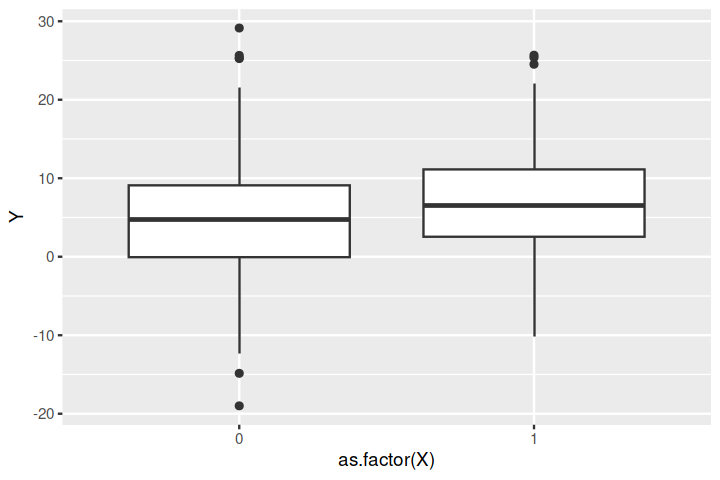

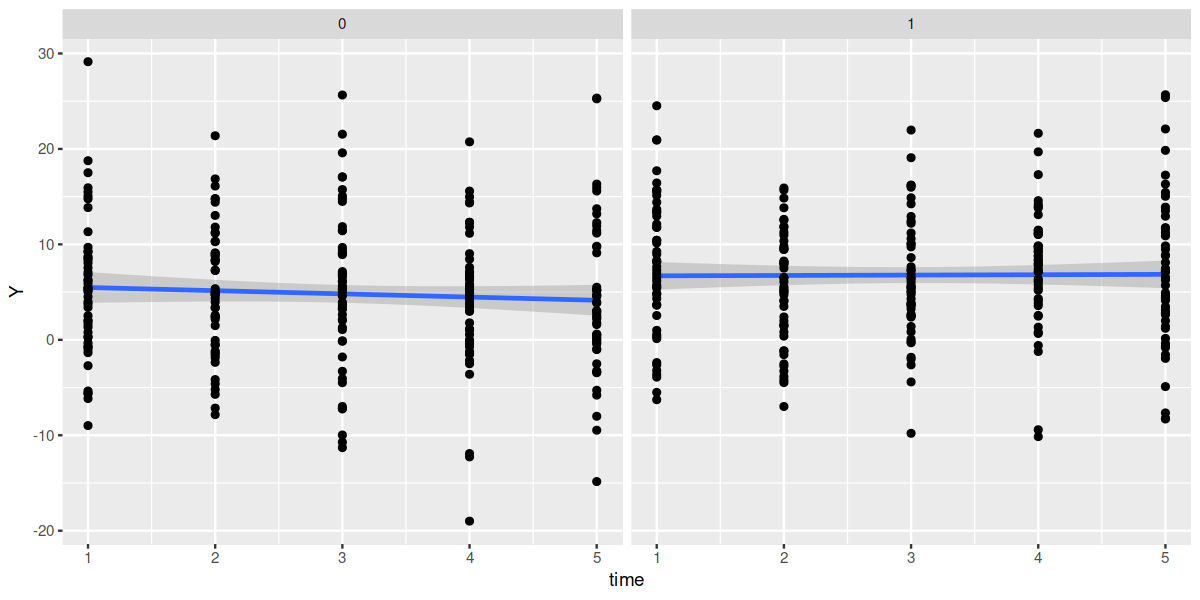

In [6]:
ols <- lm(Y ~ time*X, data)
summary(ols)

ri <- lme(Y ~ time*X, random = ~1|subject, data)
summary(ri)

options(repr.plot.width=6, repr.plot.height=4)

data %>%
    arrange(subject) %>%
    ggplot(aes(x=as.factor(X), y=Y)) + 
    geom_boxplot() 

options(repr.plot.width=10, repr.plot.height=5)

data %>%
    arrange(subject) %>%
    ggplot(aes(x=time, y=Y)) + 
    geom_smooth(method = "lm") + 
    geom_point() + 
    facet_wrap(~X) 

In [144]:
# creating covariance structure

n=30
t = 4
M <- rep(0,t) # vector of means

# Covariance matrix 
# V <- matrix(c(1, 0.5, 0.0, 0.0,
#               0.5, 1, 0.5, 0.0,
#               0.0, 0.5, 1, 0.5,
#               0.0, 0.0, 0.5, 1), nrow = t, byrow = TRUE)

rho = .9
sigma = 1
V <- sigma^2 * matrix(c(1, rho, rho^2, rho^3, 
              rho, 1, rho, rho^2, 
              rho^2, rho, 1, rho, 
              rho^3, rho^2, rho, 1), nrow = t, byrow = TRUE)
V
set.seed(11)  

draws <- mvrnorm(n = n, mu = M, Sigma = V)
draws_df <- data.frame(draws)
names(draws_df) <- c("e1", "e2", "e3", "e4")

draws_df <- draws_df %>%
    mutate(BID = rep(1:n),
           )
cor(draws_df) # checking Cov structure

set.seed(11)  

treatment <- c(NA)
trt = c(rep('A', 15), rep('B', 15))
trt = sample(trt, replace = F)
for(i in 1:n) {
    s <- sample(trt[i], size = 1)
    treatment <- c(treatment, rep(s, t))
}
treatment <- as.factor(treatment[-1])

# subject's random effect (StdDev: Intercept) 
u_0i <- c(NA)
for(i in 1:n) {
    s <- rnorm(1, 0, sigma)
    u_0i <- c(u_0i, rep(s, t))
}
u_0i <- u_0i[-1]

# 
mu = rnorm(n, 80, 10)
beta_0 <- list(30)
for(i in 1:n) {
    beta_0[[i]] <- rep(mu[i], t)
}
beta_0 <- unlist(beta_0)


u_1i <- c(NA)
for(i in 1:n) {
    s = rep(-1,t)
    u_1i <- c(u_1i, rep(s, t))
}
u_1i <- u_1i[-1]

df_long <- reshape(draws_df, varying = paste0("e", 1:t), v.names = "e", 
                    direction = "long") %>%
    arrange(BID) %>%
    mutate(time = factor(rep(1:t, n)),
           Treatment = treatment) %>%
    dplyr::select(-BID)


weight <- beta_0 + u_0i + ifelse(treatment=='B', 0, as.numeric(df_long$time)*u_1i) + df_long$e
df_long <- df_long %>%
    mutate(Weight = weight) 

df_long %>%
    head()

df_long %>%
    # group_by(Treatment, time) %>%
    summarise(mean(Weight), .by = Treatment)

df_long %>%
    # group_by(Treatment, time) %>%
    summarise(mean(Weight), .by = time)

1.000,0.90,0.81,0.729
0.900,1.00,0.90,0.810
0.810,0.90,1.00,0.900
0.729,0.81,0.90,1.000


,e1,e2,e3,e4,BID
e1,1.0000000,0.78933664,0.71586287,0.5754709,0.10265452
e2,0.7893366,1.00000000,0.86903554,0.7061573,0.06551985
e3,0.7158629,0.86903554,1.00000000,0.8336674,-0.03297693
e4,0.5754709,0.70615735,0.83366736,1.0000000,-0.20636000
BID,0.1026545,0.06551985,-0.03297693,-0.2063600,1.00000000


,time,e,id,Treatment,Weight
,<fct>,<dbl>,<int>,<fct>,<dbl>
1.1,1,-0.08058804,1,B,97.33924
1.2,2,0.72314110,1,B,98.14297
1.3,3,0.67891887,1,B,98.09874
1.4,4,0.88410129,1,B,98.30393
2.1,1,0.09100447,2,A,70.99527
2.2,2,-0.70146722,2,A,69.20280


Treatment,mean(Weight)
<fct>,<dbl>
B,80.27273
A,76.97094


time,mean(Weight)
<fct>,<dbl>
1,79.32564
2,78.89829
3,78.38908
4,77.87432


In [153]:
ols <- lm(Weight ~ Treatment*as.numeric(time), df_long)
summary(ols)

(paste('######################## Random Intercept ###############################'))
ri <- lme(Weight ~ Treatment*as.numeric(time), random = ~1|id, df_long)
summary(ri)

(paste('######################## AR1 ###############################'))
ri <- lme(Weight ~ Treatment*as.numeric(time), random = ~1|id, correlation = corAR1(form = ~1|id), df_long)
summary(ri)
car::Anova(ri)

(paste('######################## Random Slope ###############################'))
ri <- lme(Weight ~ Treatment*as.numeric(time), random = ~1+Treatment|id, df_long)
summary(ri)
car::Anova(ri)

# df_long %>%
#     ggplot(aes(x=as.factor(Sex), y=Weight)) + 
#     geom_boxplot() 


Call:
lm(formula = Weight ~ Treatment * as.numeric(time), data = df_long)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.931  -7.734  -0.970   6.551  24.113 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  79.3468     2.9838  26.592   <2e-16 ***
TreatmentB                    0.9816     4.2198   0.233    0.816    
as.numeric(time)             -0.9504     1.0895  -0.872    0.385    
TreatmentB:as.numeric(time)   0.9281     1.5408   0.602    0.548    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.436 on 116 degrees of freedom
Multiple R-squared:  0.03682,	Adjusted R-squared:  0.01191 
F-statistic: 1.478 on 3 and 116 DF,  p-value: 0.2241


[1] "######################## Random Intercept ###############################"

Linear mixed-effects model fit by REML
  Data: df_long 
      AIC      BIC    logLik
  351.533 368.0545 -169.7665

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    9.595042 0.3764617

Fixed effects:  Weight ~ Treatment * as.numeric(time) 
                               Value Std.Error DF   t-value p-value
(Intercept)                 79.34683  2.480288 88  31.99098  0.0000
TreatmentB                   0.98157  3.507657 28   0.27984  0.7817
as.numeric(time)            -0.95036  0.043470 88 -21.86237  0.0000
TreatmentB:as.numeric(time)  0.92809  0.061476 88  15.09677  0.0000
 Correlation: 
                            (Intr) TrtmnB as.n()
TreatmentB                  -0.707              
as.numeric(time)            -0.044  0.031       
TreatmentB:as.numeric(time)  0.031 -0.044 -0.707

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.4232514 -0.5563747  0.0034426  0.5752589  1.8424035 

Number of Observations: 120
Numbe

[1] "######################## AR1 ###############################"

Linear mixed-effects model fit by REML
  Data: df_long 
       AIC      BIC    logLik
  337.2504 356.5255 -161.6252

Random effects:
 Formula: ~1 | id
        (Intercept)  Residual
StdDev:    9.560699 0.8264803

Correlation Structure: AR(1)
 Formula: ~1 | id 
 Parameter estimate(s):
      Phi 
0.8597952 
Fixed effects:  Weight ~ Treatment * as.numeric(time) 
                               Value Std.Error DF   t-value p-value
(Intercept)                 79.35420  2.480722 88  31.98835  0.0000
TreatmentB                   0.92154  3.508271 28   0.26268  0.7947
as.numeric(time)            -0.95064  0.060724 88 -15.65505  0.0000
TreatmentB:as.numeric(time)  0.93359  0.085877 88  10.87122  0.0000
 Correlation: 
                            (Intr) TrtmnB as.n()
TreatmentB                  -0.707              
as.numeric(time)            -0.061  0.043       
TreatmentB:as.numeric(time)  0.043 -0.061 -0.707

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3       

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Treatment,0.8643407,1,3.525268e-01
as.numeric(time),126.9761688,1,1.880177e-29
Treatment:as.numeric(time),118.1834076,1,1.580741e-27


[1] "######################## Random Slope ###############################"

Linear mixed-effects model fit by REML
  Data: df_long 
      AIC      BIC    logLik
  355.533 377.5617 -169.7665

Random effects:
 Formula: ~1 + Treatment | id
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev       Corr  
(Intercept) 9.5950397957 (Intr)
TreatmentB  0.0001873292 0.002 
Residual    0.3764616974       

Fixed effects:  Weight ~ Treatment * as.numeric(time) 
                               Value Std.Error DF   t-value p-value
(Intercept)                 79.34683  2.480287 88  31.99099  0.0000
TreatmentB                   0.98157  3.507656 28   0.27984  0.7817
as.numeric(time)            -0.95036  0.043470 88 -21.86237  0.0000
TreatmentB:as.numeric(time)  0.92809  0.061476 88  15.09676  0.0000
 Correlation: 
                            (Intr) TrtmnB as.n()
TreatmentB                  -0.707              
as.numeric(time)            -0.044  0.031       
TreatmentB:as.numeric(time)  0.031 -0.044 -0.707

Standardized Within-Group Residuals

`geom_smooth()` using formula = 'y ~ x'


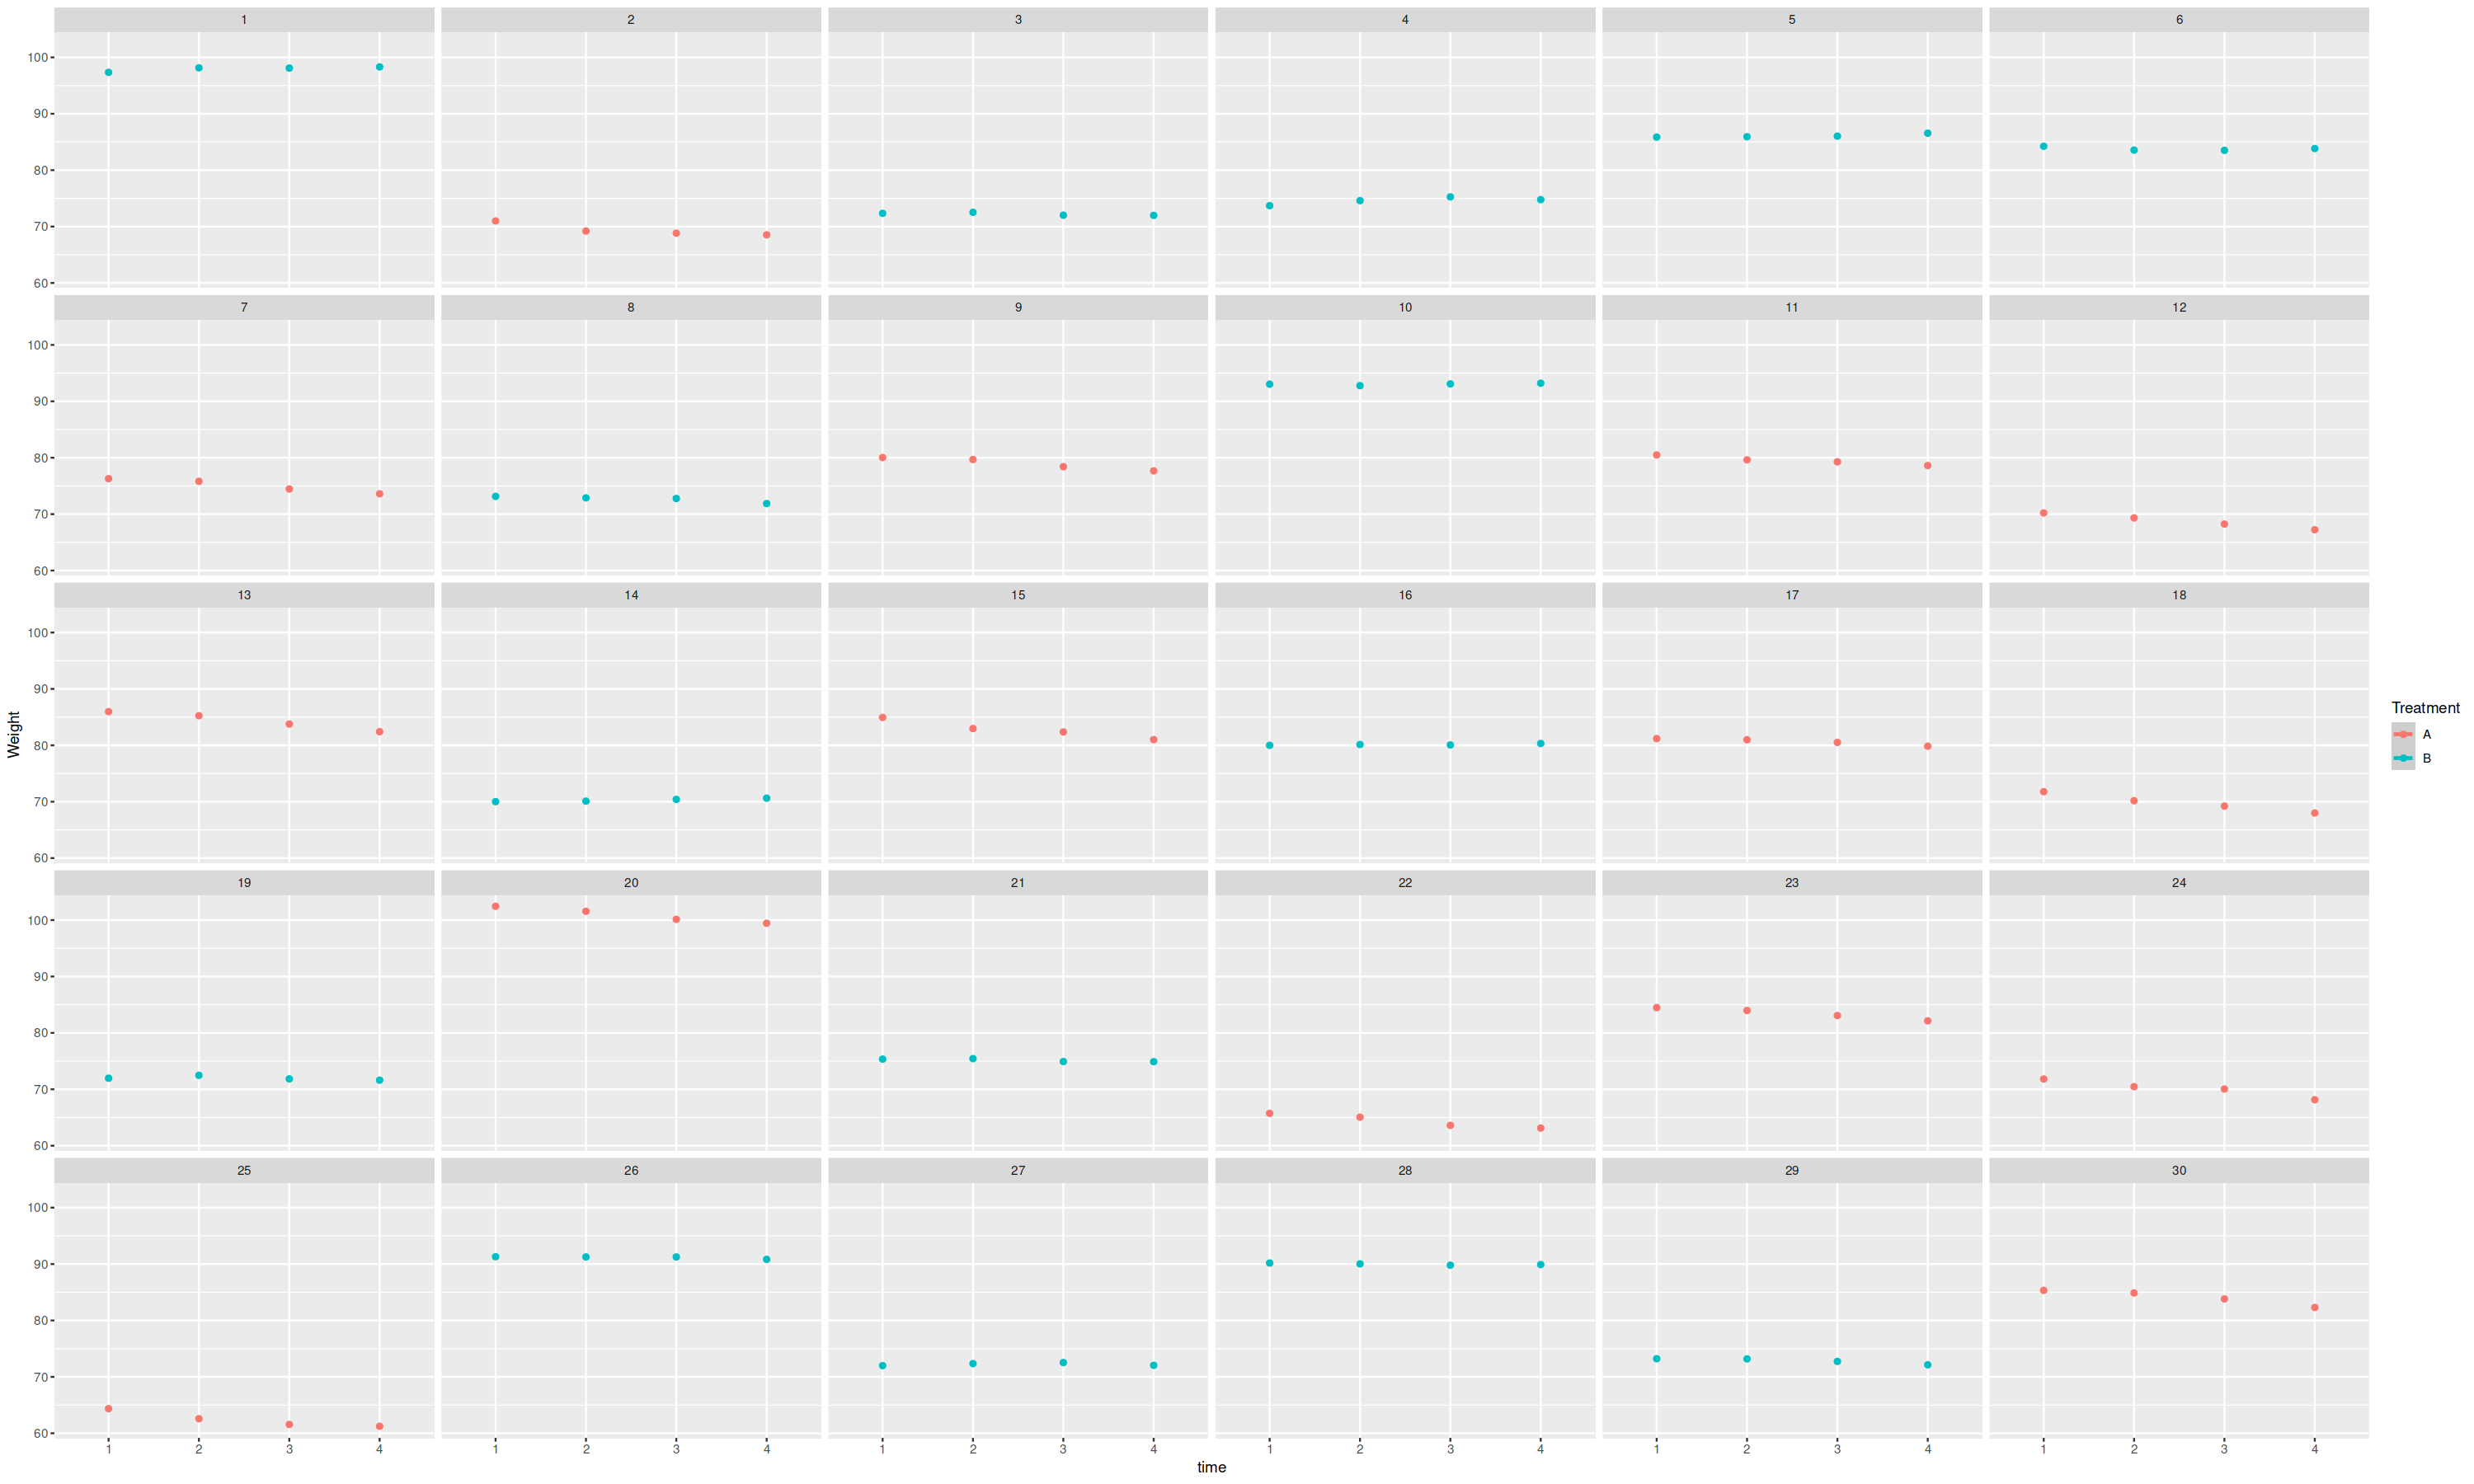

In [134]:
options(repr.plot.width=25, repr.plot.height=15)

df_long %>%
    ggplot(aes(x=time, y=Weight, col=Treatment)) + 
    geom_smooth(method = "lm") + 
    geom_point() + 
    facet_wrap(~id) 

In [157]:
### set number of individuals
n <- 30

### average intercept and slope
beta0 <- 1.0
beta1 <- 6.0

### true autocorrelation
ar.val <- .4

### true error SD, intercept SD, slope SD, and intercept-slope cor
sigma <- 1.5
tau0  <- 2.5
tau1  <- 2.0
tau01 <- 0.3

### maximum number of possible observations
m <- 4

### simulate number of observations for each individual
p <- round(runif(n,4,m))
p

[1] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

In [162]:
### simulate observation moments (assume everybody has 1st obs)
obs <- unlist(sapply(p, function(x) c(1, sort(sample(2:m, x-1, replace=FALSE)))))
obs
### set up data frame
dat <- data.frame(id=rep(1:n, times=p), obs=obs)

### simulate (correlated) random effects for intercepts and slopes
mu  <- c(0,0)
S   <- matrix(c(1, tau01, tau01, 1), nrow=2)
S 
                     
                     
tau <- c(tau0, tau1)
S   <- diag(tau) %*% S %*% diag(tau)
S
U   <- mvrnorm(n, mu=mu, Sigma=S)
U
### simulate AR(1) errors and then the actual outcomes
dat$eij <- unlist(sapply(p, function(x) arima.sim(model=list(ar=ar.val), n=x) * sqrt(1-ar.val^2) * sigma))
dat$yij <- (beta0 + rep(U[,1], times=p)) + (beta1 + rep(U[,2], times=p)) * log(dat$obs) + dat$eij

### note: use arima.sim(model=list(ar=ar.val), n=x) * sqrt(1-ar.val^2) * sigma
### construction, so that the true error SD is equal to sigma

### create grouped data object
dat <- groupedData(yij ~ obs | id, data=dat)

### profile plots
plot(dat, pch=19, cex=.5)

### fit corresponding growth model
res <- lme(yij ~ log(obs), random = ~ log(obs) | id, correlation = corAR1(form = ~ 1 | id), data=dat)
summary(res)

1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
3,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
4,4,4,4,4,4,4,4,4,4,⋯,4,4,4,4,4,4,4,4,4,4


1.0,0.3
0.3,1.0


6.25,1.5
1.50,4.0


2.2937841,2.52379716
0.2596296,-0.28569479
-0.7962968,1.75142670
-0.8990189,2.50867779
1.8020129,0.59063425
3.5844700,0.07399679
2.7250646,1.99011238
2.7513362,-1.14447428
1.7487936,-0.04599524
-2.8630849,-0.95872639
0.3986169,2.82011572


ERROR: Error in `$<-.data.frame`(`*tmp*`, eij, value = structure(c(-1.2087202568567, : replacement has 4 rows, data has 120


In [736]:
library(dplyr)
library(readxl)
organizace <- read_excel("organizace.xlsx")
sportovci <- read_excel("sportovci.xlsx")


df <- organizace %>%
    filter(Stav=='Ověřeno') %>%
    left_join(sportovci%>%select(IČO, Počet.sportovců, Počet.trenérů), by='IČO') 


#Které jsou čtyři nejčastější právní formy sportovních organizací? 
df %>%
    group_by(Právní.forma) %>%
    tally()

#Liší se pořadí této čtveřice v jednotlivých krajích?
df %>%
    group_by(Kraj, Právní.forma) %>%
    tally()

#Pro nejčastější typ organizace určete podíl těch, které mají
#alespoň jednoho registrovaného sportovce, ale žádného trenéra,
df %>%
    filter(Typ.organizace=='Klub / TJ', Počet.sportovců>0, Počet.trenérů==0) %>%
    tally()

#alespoň jednoho registrovaného trenéra, ale žádného sportovce.
df %>%
    filter(Typ.organizace=='Klub / TJ', Počet.sportovců==0, Počet.trenérů>0) %>%
    tally()

#Zjistěte, kolik sportovních organizací v jednotlivých krajích ve svém názvu obsahují řetězec “šach” nebo “bridž” bez ohledu na velikost písmen.
df %>%
    group_by(Kraj) %>%
    mutate(Název = tolower(Název)) %>%
    filter(grepl('šach|bridž', Název))  %>%
    tally()